# Pretrain Policy with  `MPC dataset`

In [1]:
import numpy as np
import pickle
from typing import Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from mujoco_parser import MuJoCoParserClass
import torch.optim as optim

from tqdm import tqdm
import matplotlib.pyplot as plt
from util import r2quat

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from policy import GaussianPolicy
from pid import PID_ControllerClass

import mediapy as media

### Load  `MPC dataset`

In [2]:
with open(file='../data/Atlas_MPC_dataset_240403.pkl', mode='rb') as f:
    dataset = pickle.load(f)

horizon = 50
action = torch.Tensor(dataset['action'])
root_pos = torch.Tensor(dataset['root_pos'])
root_rot = torch.Tensor(dataset['root_rot'])
root_vel = torch.Tensor(dataset['root_vel'])
root_ang_vel = torch.Tensor(dataset['root_ang_vel'])
dof_pos = torch.Tensor(dataset['dof_pos'])
dof_vel = torch.Tensor(dataset['dof_vel'])
local_key_pos = torch.Tensor(dataset['local_key_pos'])

del dataset



# qpos_batch = qpos_batch[:, :]
# qpos_batch = torch.cat((qpos_batch[:-2, :],qpos_batch[1:-1, :],qpos_batch[2:, :]),dim=1)
# qvel_batch = torch.cat((qvel_batch[:-2, :],qvel_batch[1:-1, :],qvel_batch[2:, :]),dim=1)

obs = torch.cat((root_pos[:,2:3], root_rot, root_vel, root_ang_vel, dof_pos, dof_vel, local_key_pos.reshape(-1, 12)), dim=1)
# obs = torch.cat((root_pos, root_rot, root_vel, root_ang_vel, dof_pos, dof_vel), dim=1)

# action_batch = action_batch[2:]
obs_dim = obs.shape[1]
action_dim = action.shape[1]
hidden_dim = 256

print("obs : ", obs.shape)
print("action : ", action.shape)


obs :  torch.Size([15750, 83])
action :  torch.Size([15750, 30])


In [3]:
xml_path = '../asset/atlas_v5/scene_atlas.xml'
env = MuJoCoParserClass(name='smplrig',rel_xml_path=xml_path,VERBOSE=True)
# Modify the color of body exluding 'world'
for body_name in env.body_names:
    if body_name in ['world']: continue
    body_idx = env.body_names.index(body_name)
    geom_idxs = [idx for idx,val in enumerate(env.model.geom_bodyid) if val==body_idx]
    for geom_idx in geom_idxs:
        env.model.geom(geom_idx).rgba = [0.3,0.3,0.5,0.5]
print ("Done.")

dt:[0.0083] HZ:[120]
n_dof (=nv):[36]
n_geom:[128]
geom_names:['floor', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 'l_foot', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 'r_foot', None, None]
n_body:[32]
body_names:['world', 'pelvis', 'ltorso', 'mtorso', 'utorso', 'head', 'l_clav', 'l_scap', 'l_uarm', 'l_larm', 'l_ufarm', 'l_lfarm', 'l_hand', 'r_cl

In [10]:
policy = GaussianPolicy(
    input_dim=obs_dim,
    output_dim=action_dim,
    hidden_dim=hidden_dim,
    is_deterministic=False,
)

RunningMeanStd:  83
RunningMeanStd:  30


In [11]:
class MPCDataset(Dataset):
    def __init__(self, obs, act):
        self.obs = obs
        # self.obs = (self.obs - self.obs.mean(dim=0)) / self.obs.std(dim=0)
        self.act = act
        # self.act = (self.act - self.act.mean(dim=0)) / self.act.std(dim=0)
        assert self.obs.shape[0] == self.act.shape[0]

    def __len__(self):
        return self.obs.shape[0]

    def __getitem__(self,idx):
        return self.obs[idx], self.act[idx]

In [12]:
train_dataset = MPCDataset(obs, action)
train_dataloader = DataLoader(train_dataset, batch_size=2048, shuffle=True)
# test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [13]:
train_dataset.obs[0]

tensor([ 9.1989e-01,  7.3652e-01,  4.9616e-02,  1.5951e-02, -6.7441e-01,
        -1.2861e-01, -1.4489e+00,  7.7746e-02, -5.7594e-01, -1.2480e-01,
         1.5255e-01, -2.4939e-02, -2.1939e-01, -8.3251e-02,  0.0000e+00,
        -2.1702e-01,  1.5576e+00,  8.6810e-01,  9.5014e-01,  8.8791e-01,
        -5.2108e-01,  4.0094e-01, -7.8540e-01,  1.0829e+00,  6.4794e-01,
        -1.6561e-01, -2.2766e-03,  1.4926e-01,  6.6062e-01, -8.1672e-02,
        -4.3860e-02,  1.9384e-01,  5.1655e-01, -8.0491e-01, -1.5126e-02,
        -8.8078e-02, -3.1161e-02, -7.4857e-01,  7.1844e-01, -6.4623e-02,
        -1.2410e-02, -7.2821e-01,  6.6613e-16,  1.1375e+00,  0.0000e+00,
         2.6854e+00,  8.8535e-01, -3.2399e-01, -1.3362e+00,  2.1848e-03,
        -5.0832e-01,  2.8987e+00, -5.3291e-15,  2.7069e-01,  7.9454e-01,
        -1.7454e+00, -9.1401e-01,  6.5297e-01, -9.1594e-01, -9.0684e-02,
         8.1702e-01,  6.3165e-01, -3.5649e-01, -1.0986e-01, -3.0787e-01,
        -1.3838e-01,  7.3367e-01,  1.3359e+00,  1.4

### PID

In [14]:
ctrl_ranges     = env.model.actuator_ctrlrange
n_ctrl          = env.model.nu
PID = PID_ControllerClass(
        name = 'PID',dim = n_ctrl,
        k_p = 0.001, k_i = 0.00, k_d = 0.000,
        out_min = ctrl_ranges[:,0],
        out_max = ctrl_ranges[:,1],
        dt = 0.00833,
        ANTIWU  = True)
PID.reset()

### Training Loop

In [17]:
num_epoch = 1000
optimizer = optim.Adam(policy.parameters(), lr=1e-3, betas=(0.9, 0.95), weight_decay=0.001)
loss = torch.nn.MSELoss()
def criterion(output: torch.tensor, y: torch.tensor, mean, std, log_prob):
    diff = output - y

    normal = Normal(mean, std)
    GT_neglogp = -normal.log_prob(y)

    logp_error = torch.mean(GT_neglogp)
    logp_coeff = 1e-2
    pred_error = (torch.mean(torch.abs(diff)))

    return pred_error# + logp_error * logp_coeff
    # return torch.mean(torch.sqrt(torch.mean(torch.square(diff),dim=1)))
    # return loss(output, y)

policy.train()
policy.running_mean_std.train()
policy.action_mean_std.train()
for epoch in range(num_epoch):
    # time = torch.arange(0,50*0.0083,0.0083)
    with tqdm(train_dataloader, unit="batch") as tepoch:
        
        for x, y in tepoch:
            
            tepoch.set_description(f"Epoch {epoch+1}")

            optimizer.zero_grad()
                
            pred_target_position, mean, std, log_prob = policy(x) # supervised

            PID.update(x_trgt=pred_target_position,x_curr=x[:,11:41],VERBOSE=False) # PD Controller
            pred_torque = PID.out()
            l = criterion(pred_torque, policy.action_mean_std(y), mean, std, log_prob)
            l.backward()
            optimizer.step()
            PID.reset()
            
            tepoch.set_postfix(loss=l.item())


Epoch 1000: 100%|██████████| 8/8 [00:00<00:00, 33.72batch/s, loss=0.636]


In [ ]:
LOAD = False
file_name = "240406_walk_atlas_pretrain_policy_PD.pth"
if not LOAD:
    torch.save(policy.state_dict(), file_name)

if LOAD:
    policy.load_state_dict((torch.load(file_name)))

### Test pretrain model

In [10]:
PLOT = True
policy.eval()
policy.running_mean_std.eval()
policy.action_mean_std.eval()
policy.is_deterministic = True

In [11]:
# Set which joints to control
ctrl_joint_names = env.ctrl_joint_names # <==
joint_idxs_fwd = env.get_idxs_fwd(joint_names=ctrl_joint_names)
joint_idxs_jac = env.get_idxs_jac(joint_names=ctrl_joint_names)
q_ctrl_init = env.get_qpos_joints(ctrl_joint_names)
n_ctrl_joint = len(ctrl_joint_names)

In [12]:
KEY_BODY_NAMES = ["r_foot", "l_foot", "r_hand", "l_hand"]
key_body_ids= np.array(env.get_idxs_body(KEY_BODY_NAMES))

In [13]:
env.data.xpos[1]

array([0., 0., 1.])

/var/folders/xg/3z5dsdd15r74bw6d3yb9_0zw0000gp/T/ipykernel_49245/1304814866.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


2024-04-09 10:40:35.612 python[49245:12675185] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit


Pressed ESC
Quitting.


Exception: GLFW window does not exist but you tried to render.

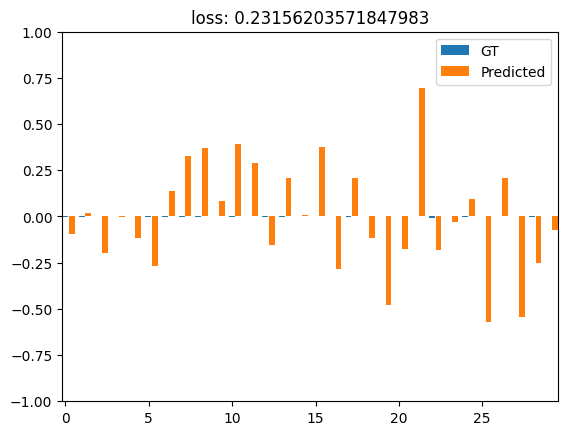

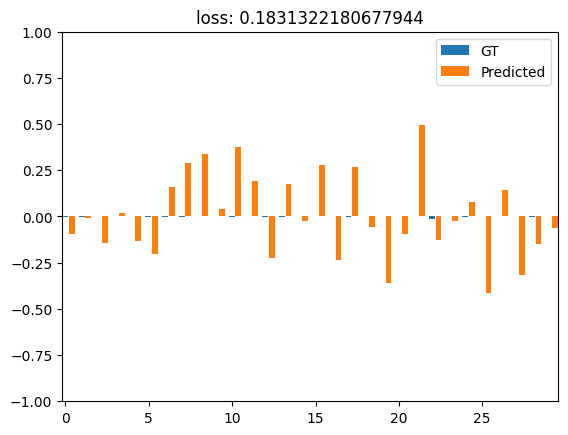

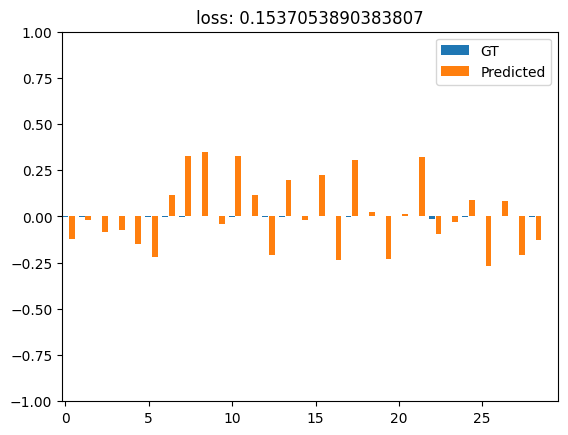

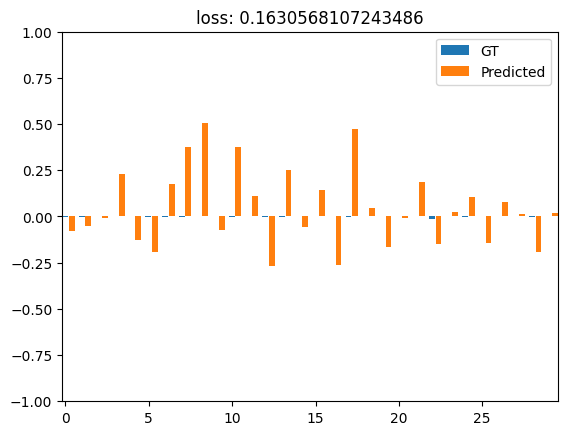

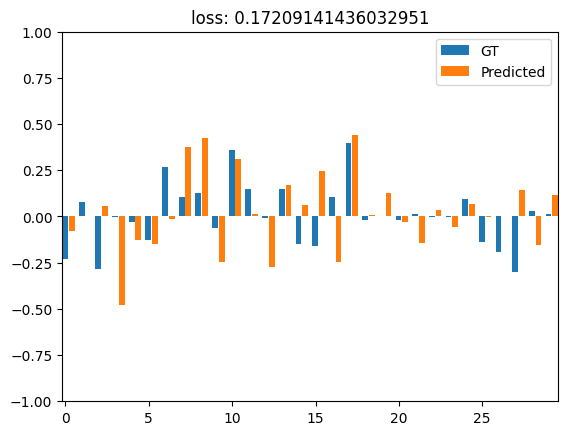

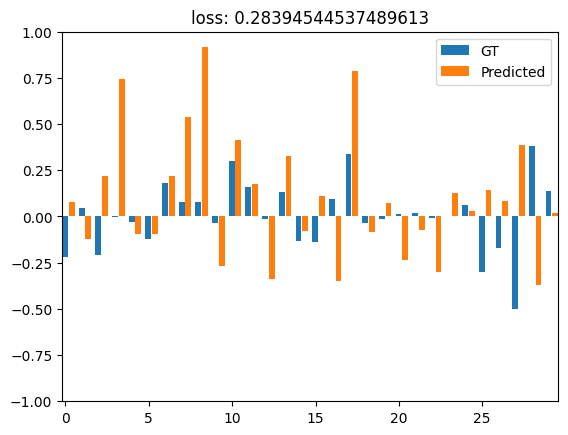

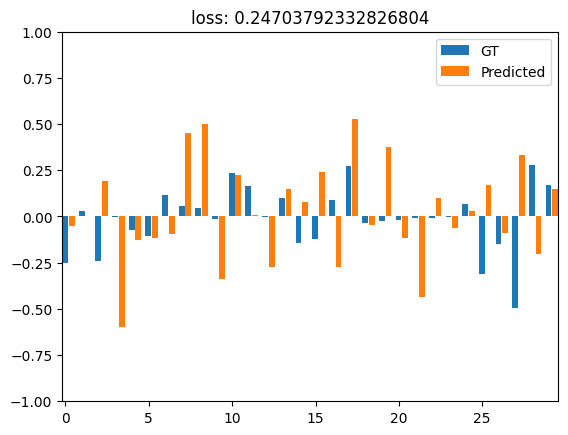

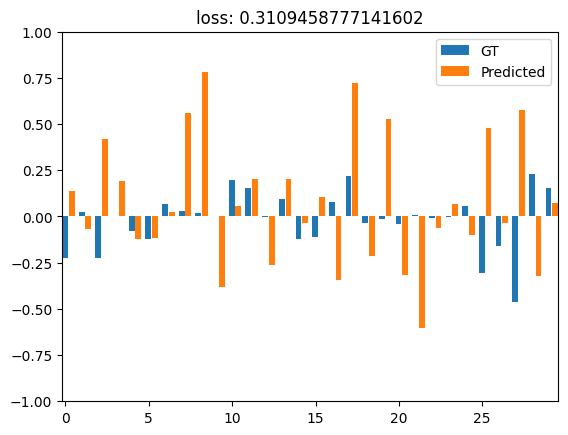

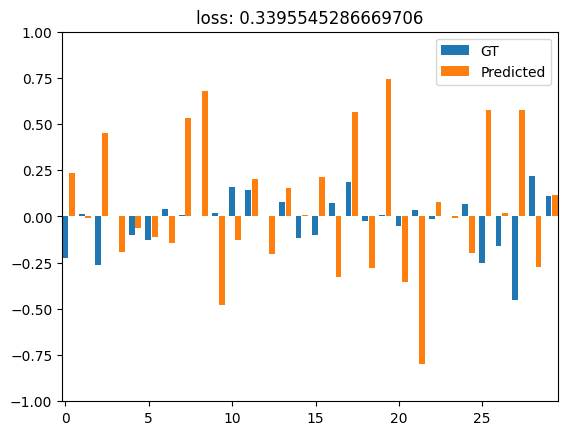

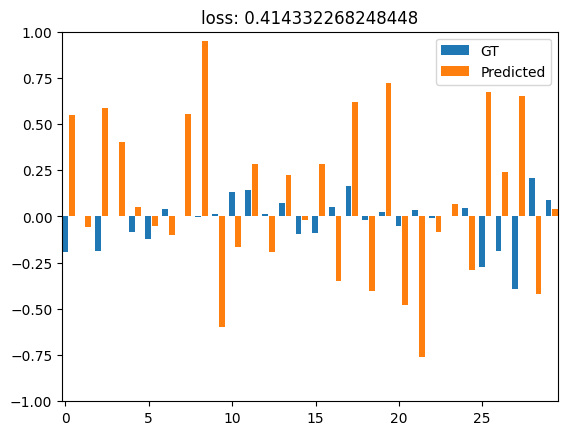

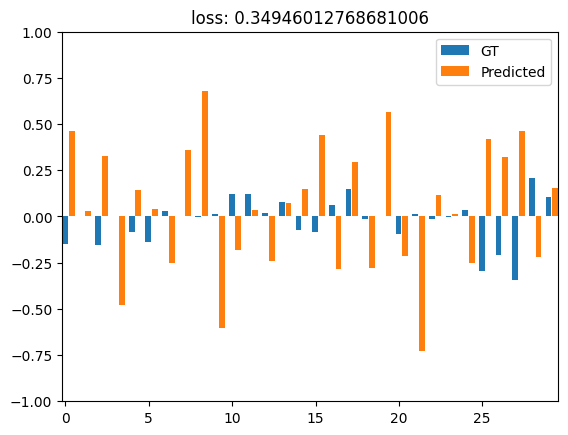

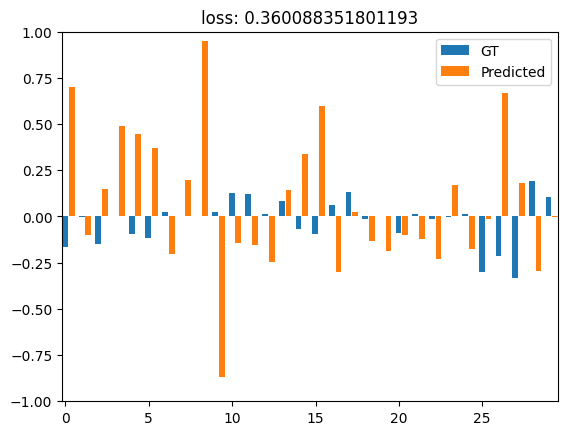

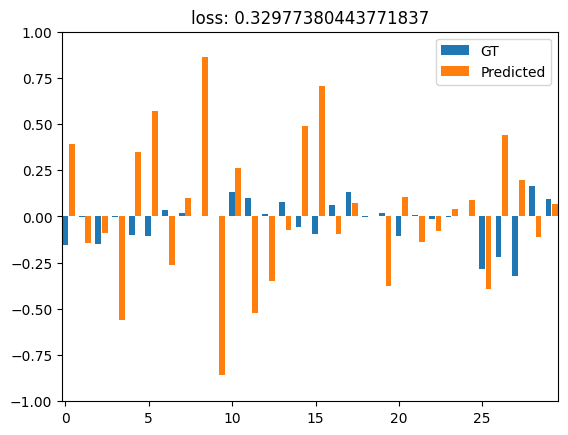

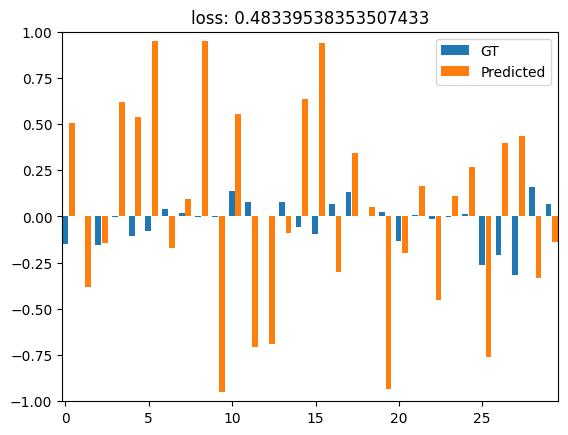

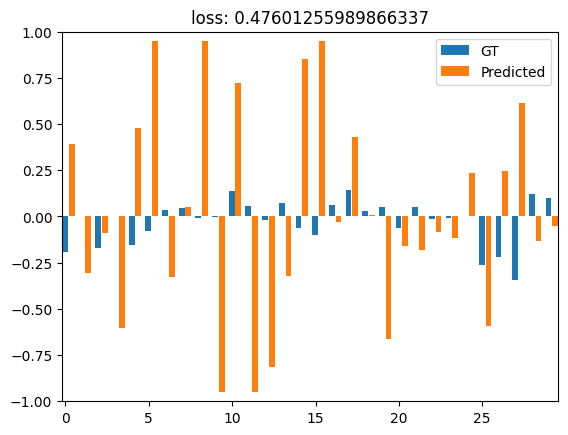

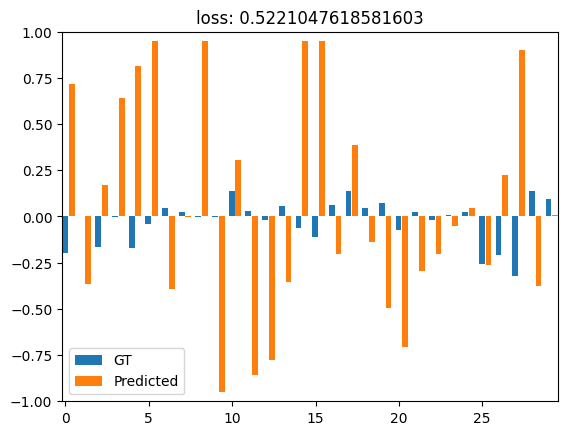

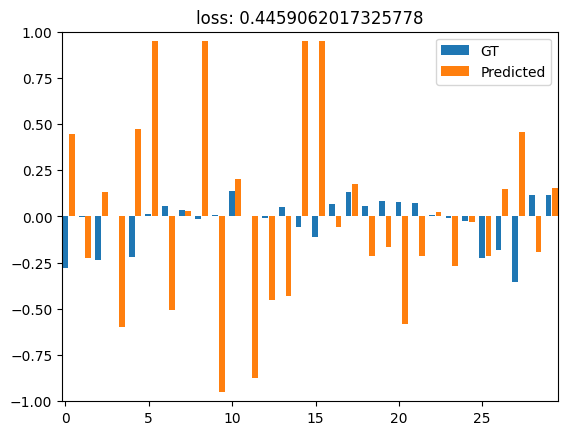

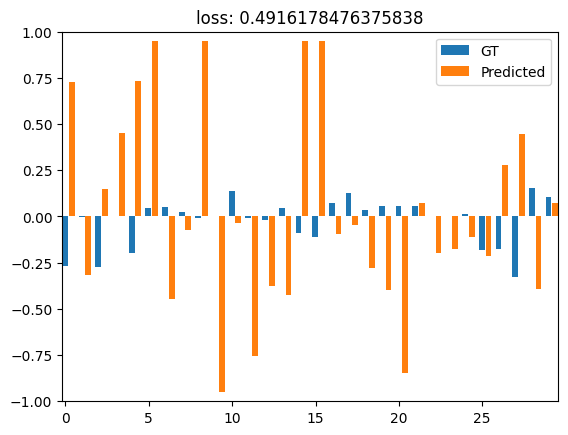

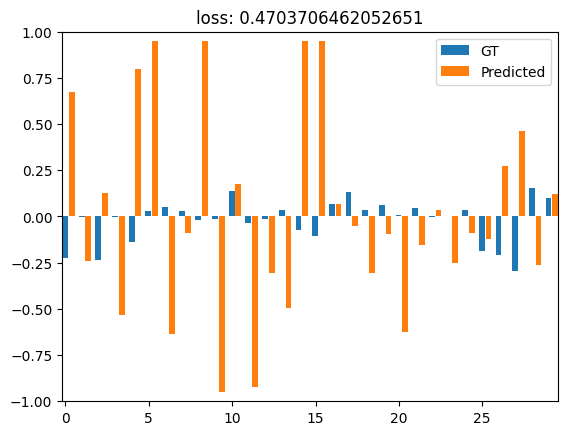

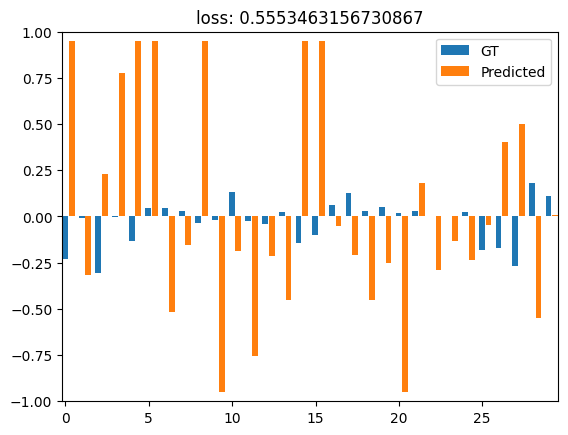

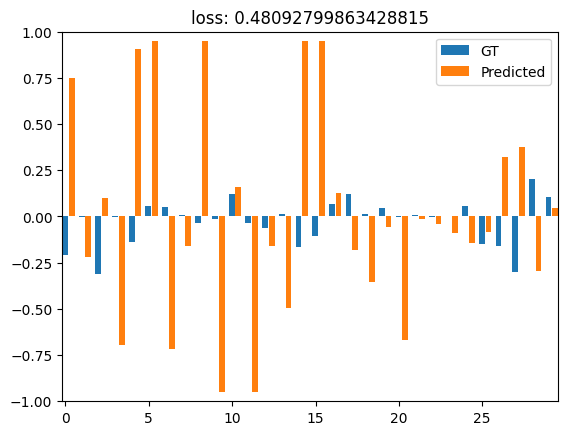

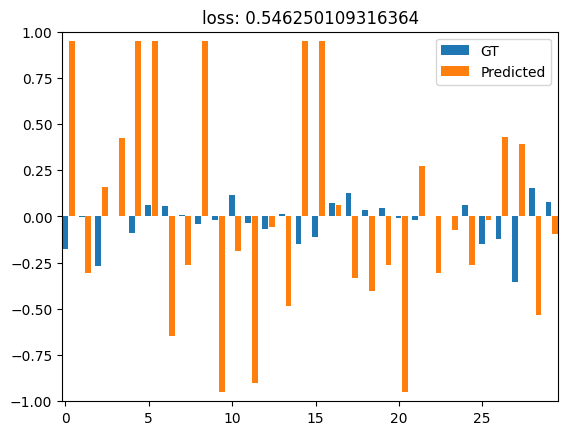

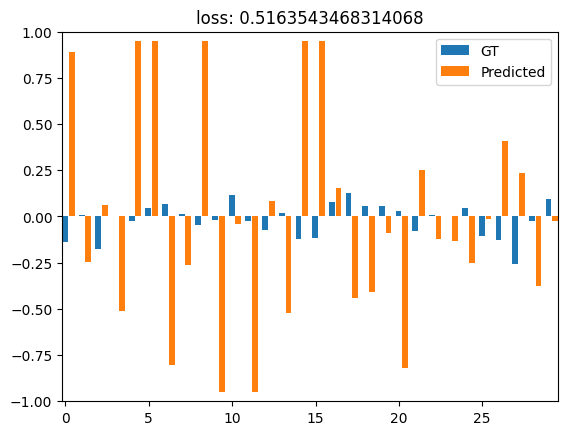

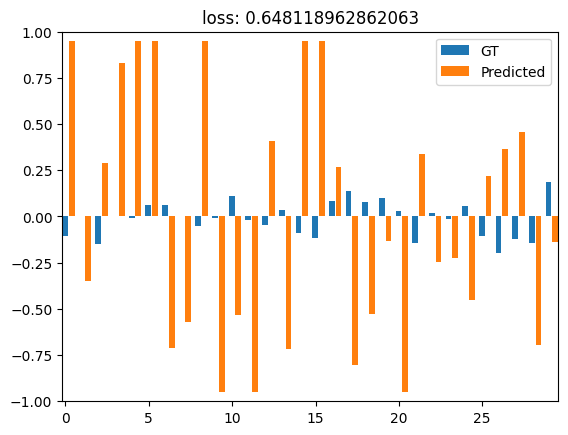

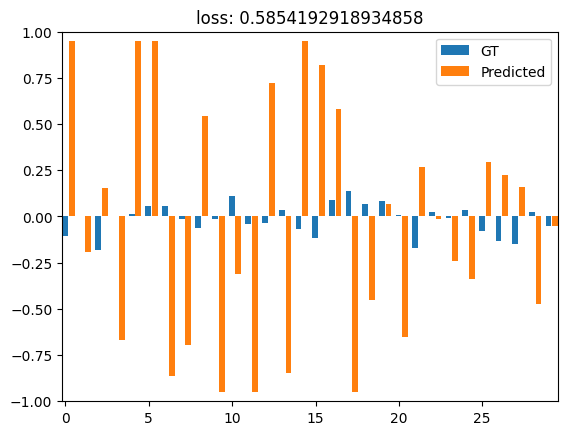

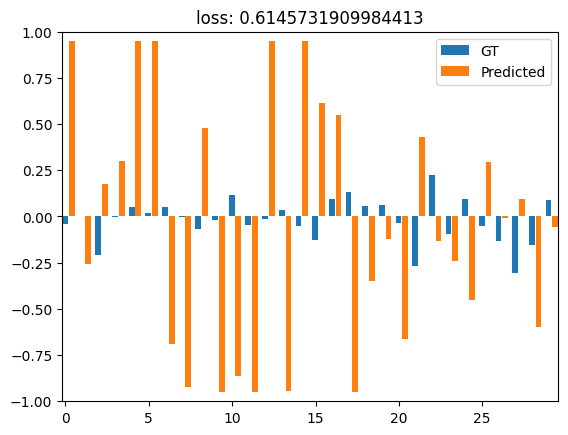

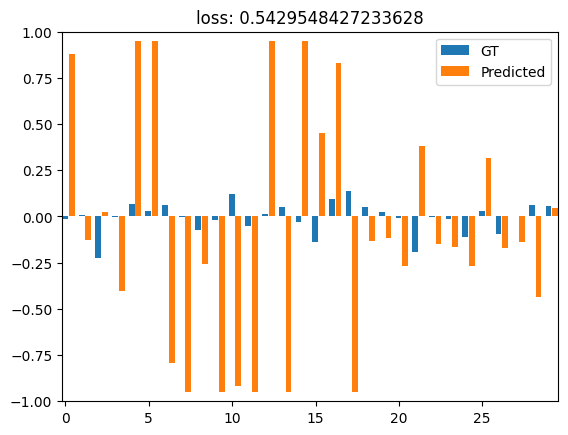

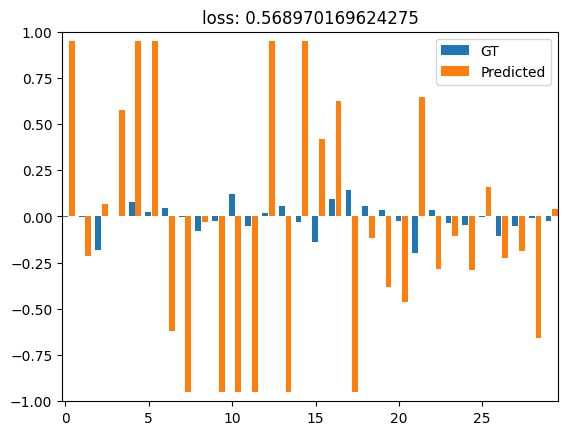

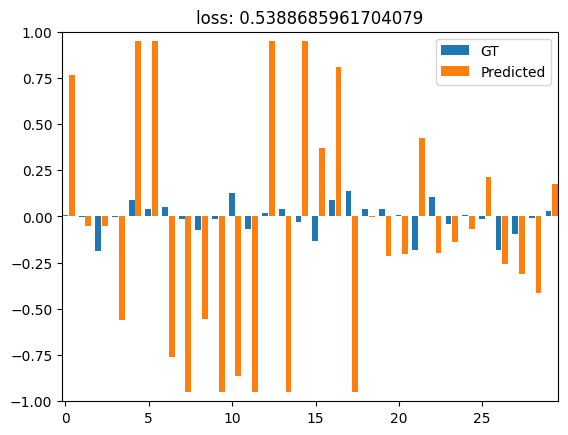

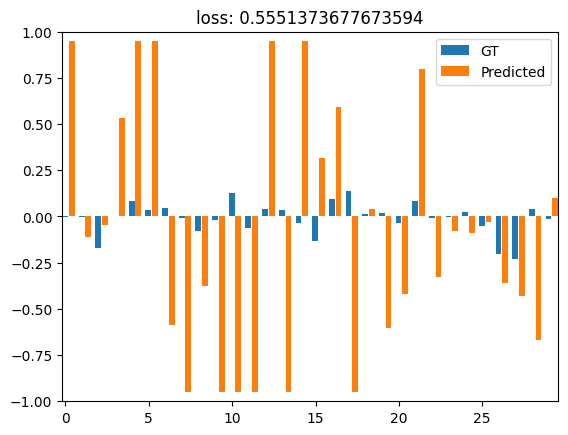

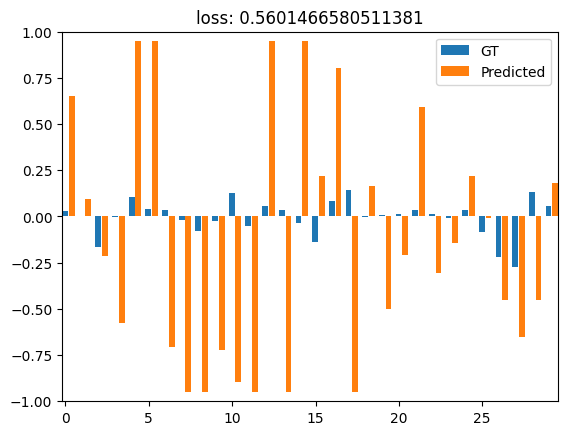

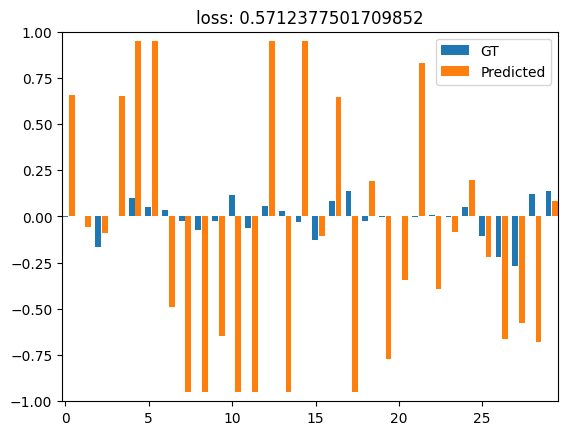

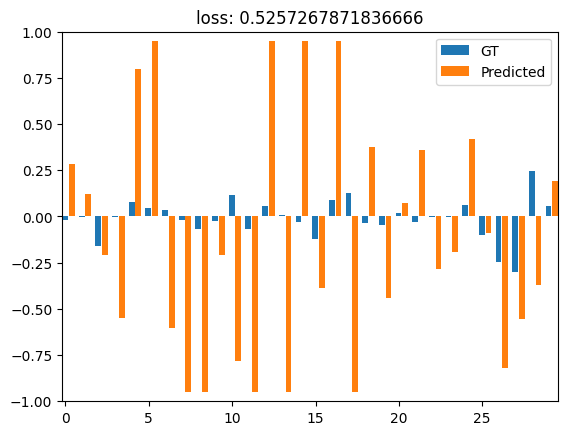

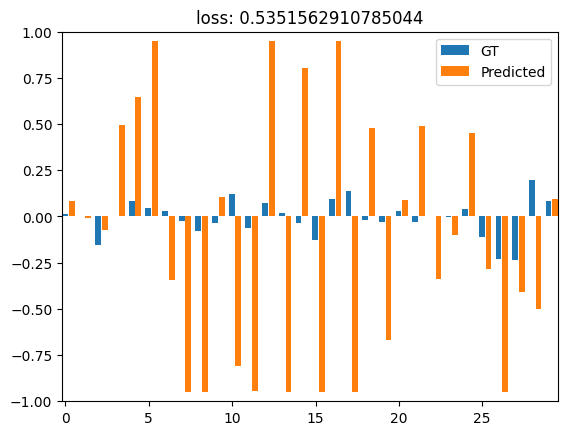

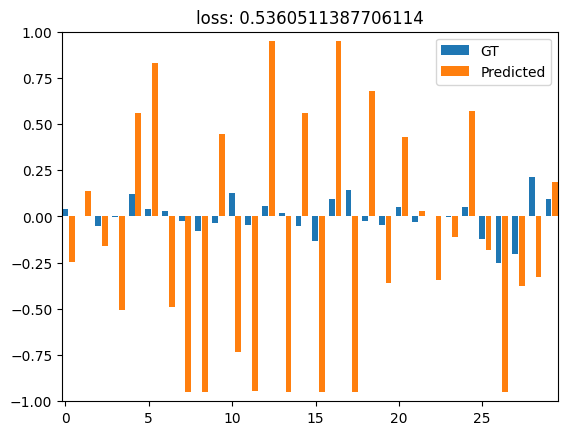

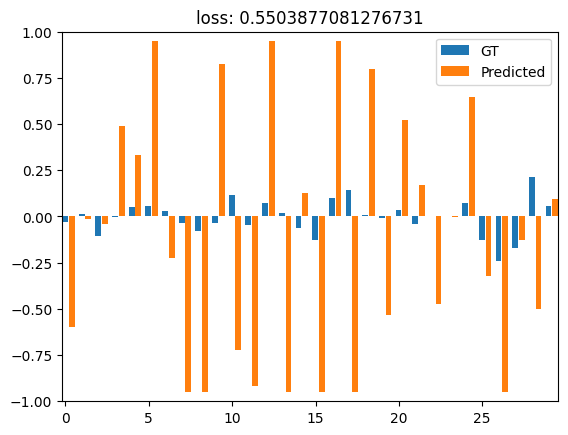

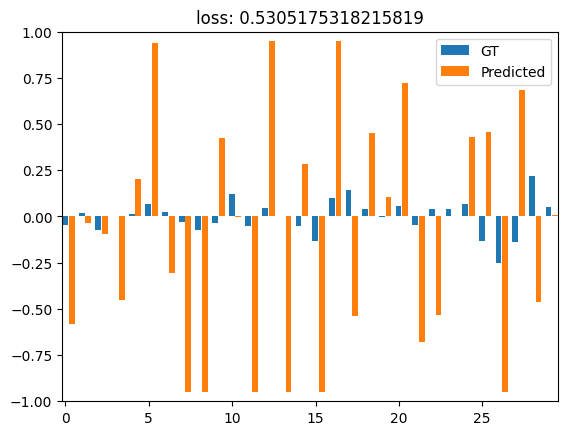

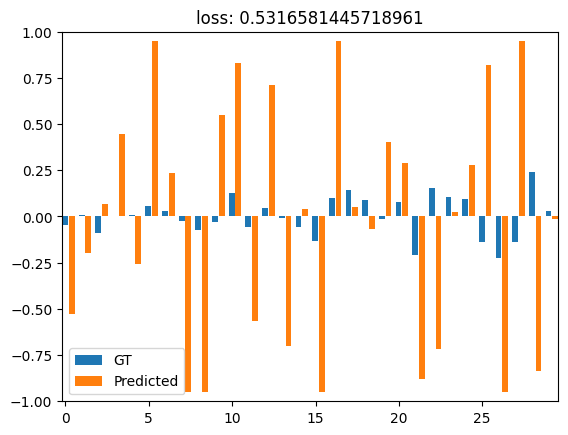

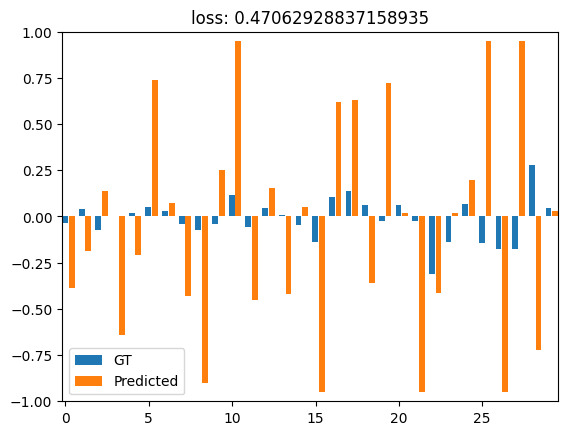

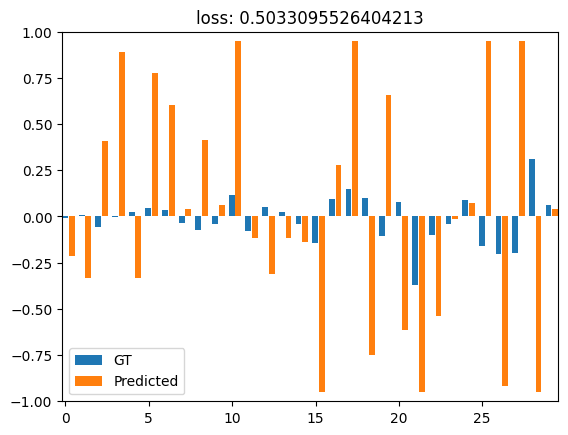

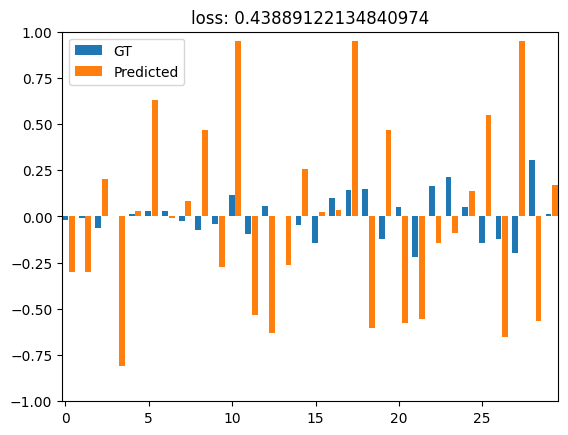

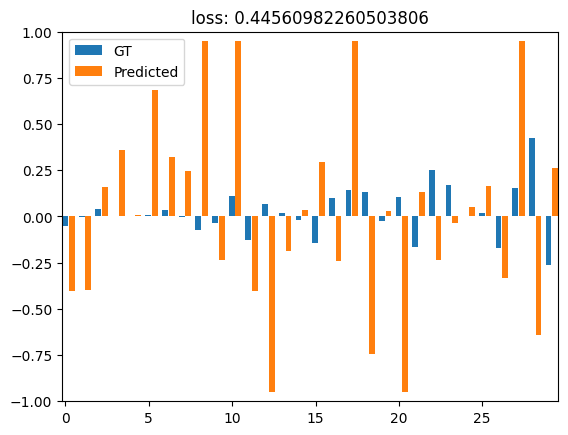

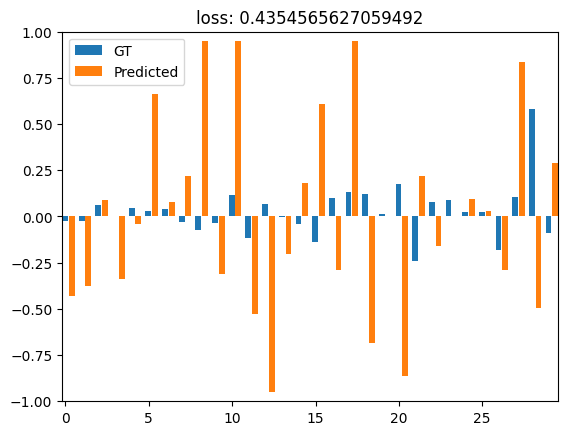

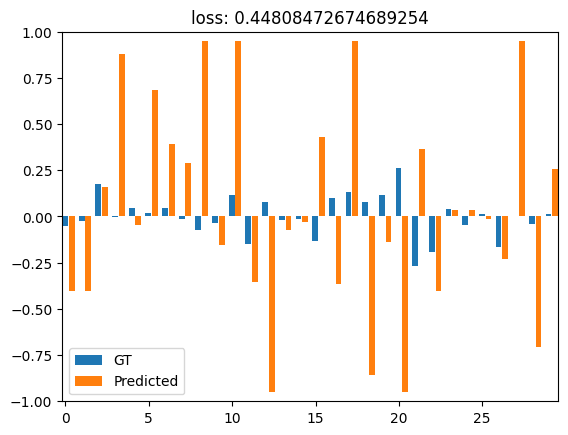

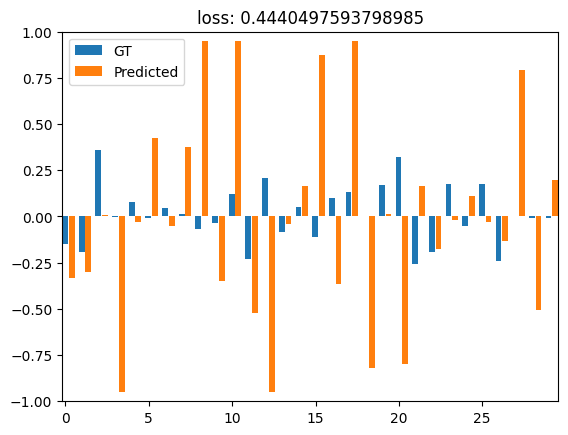

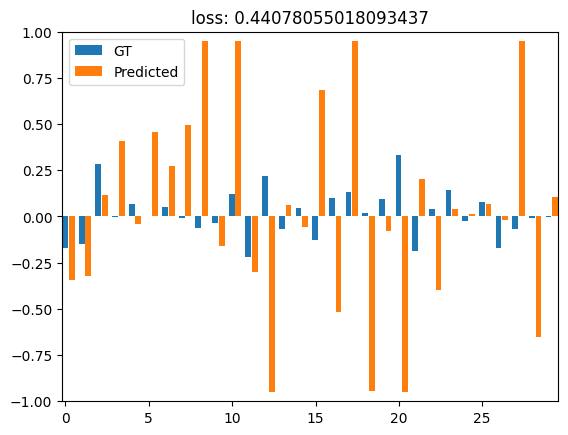

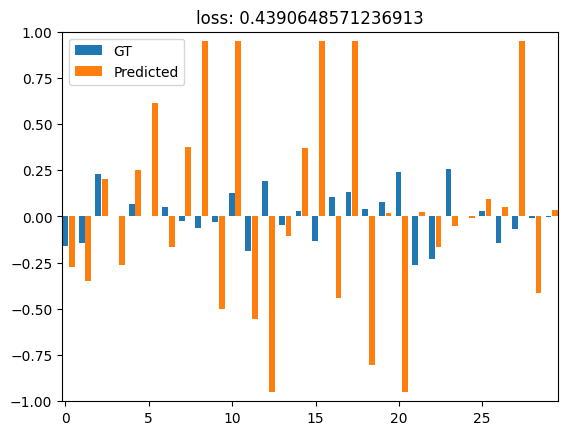

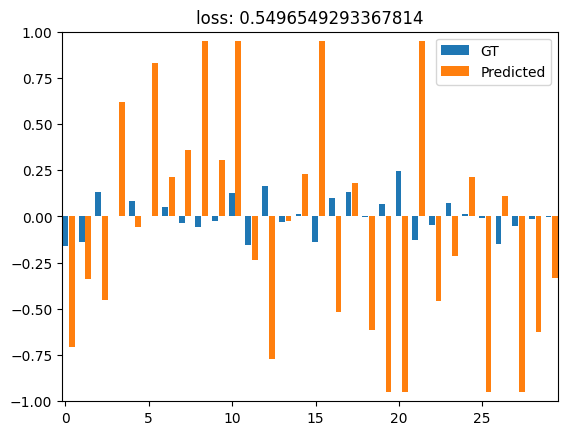

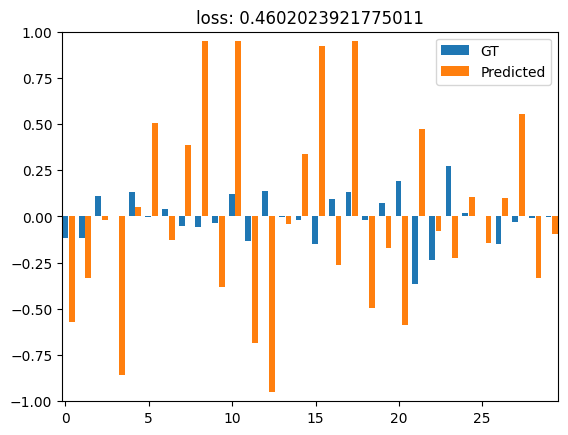

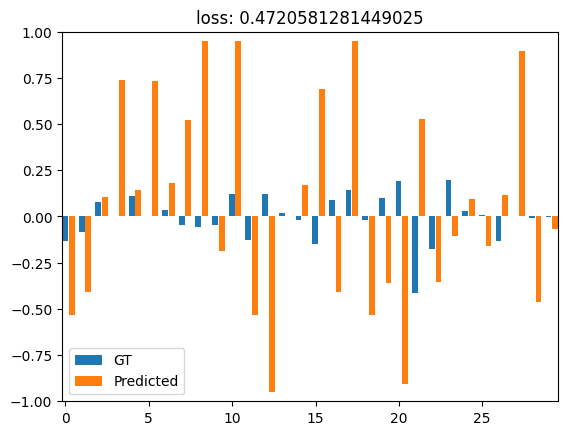

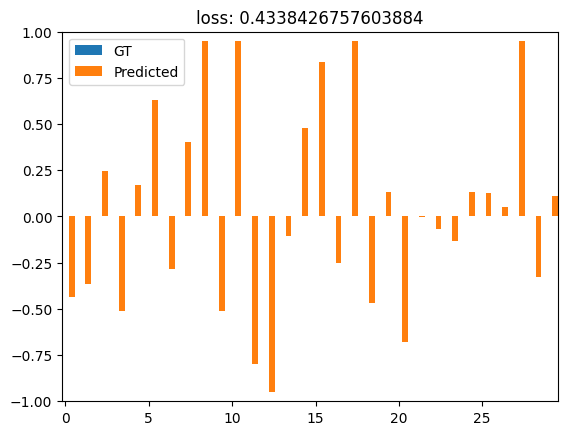

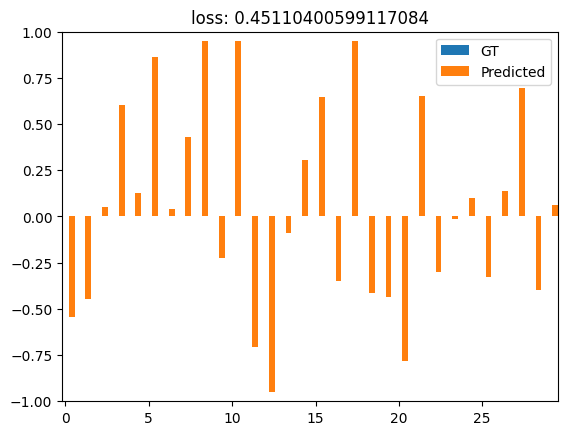

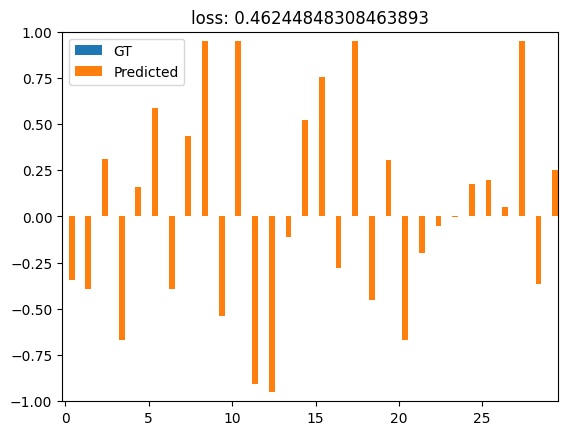

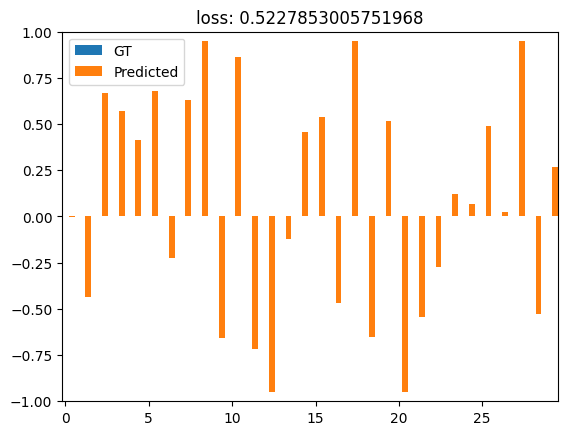

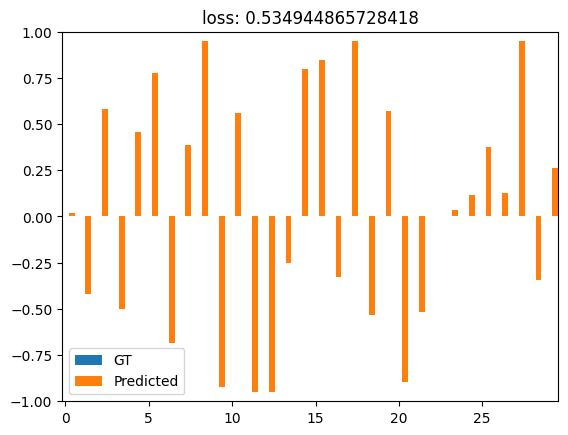

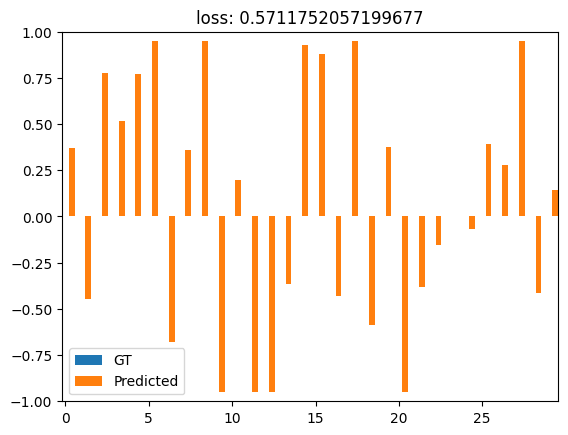

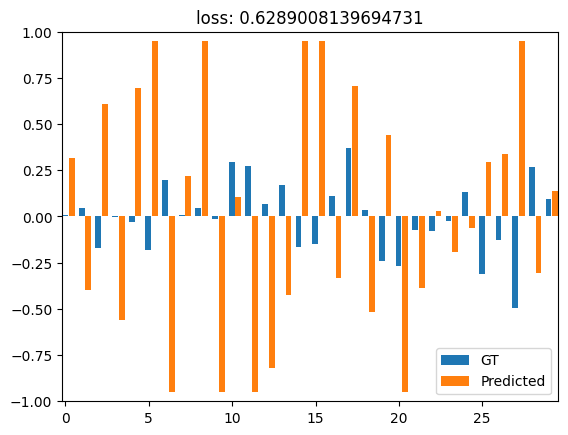

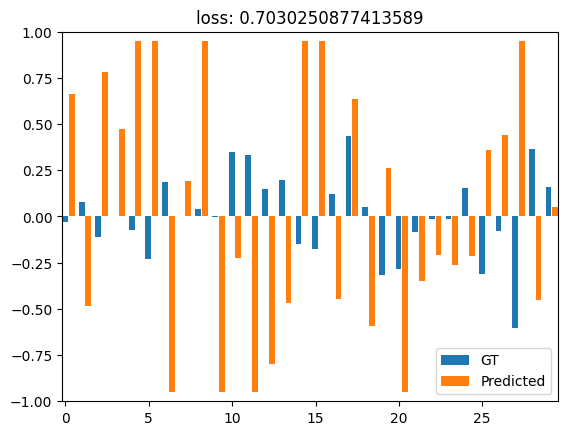

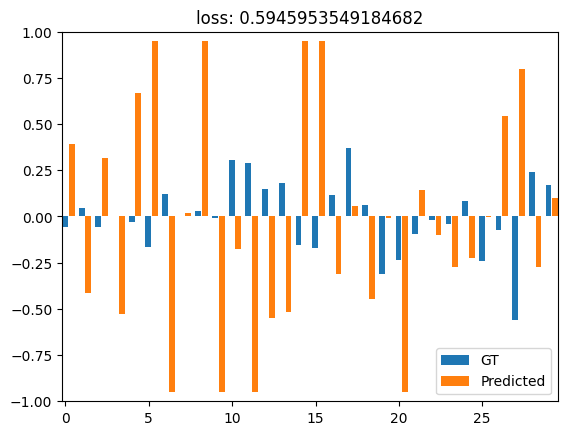

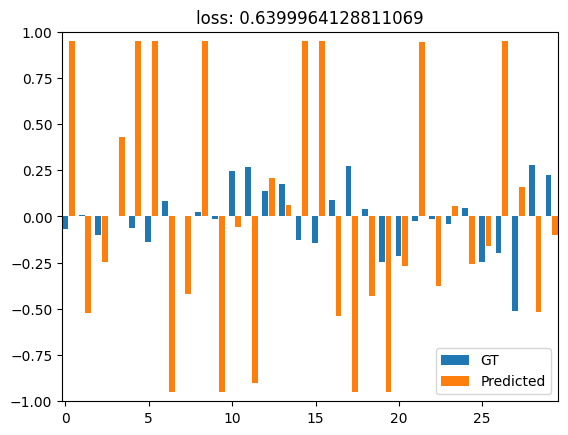

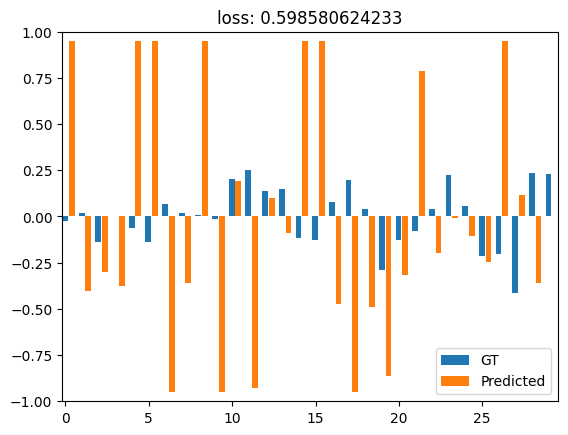

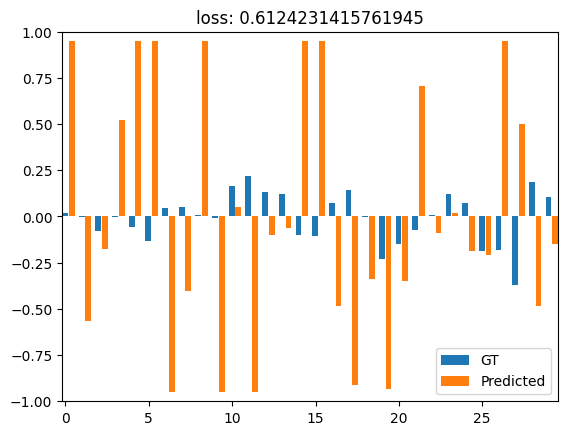

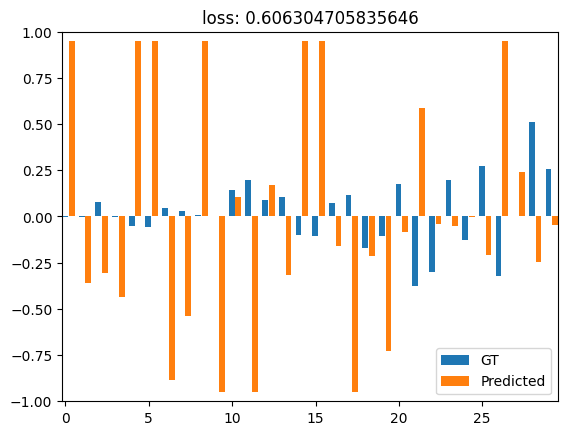

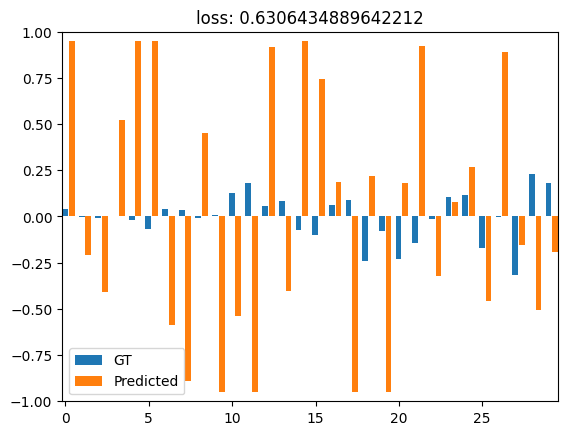

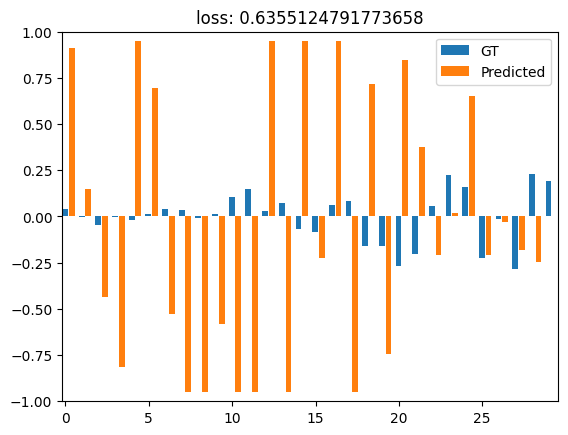

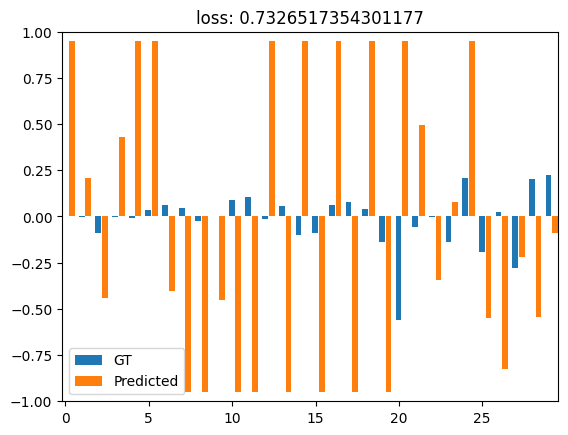

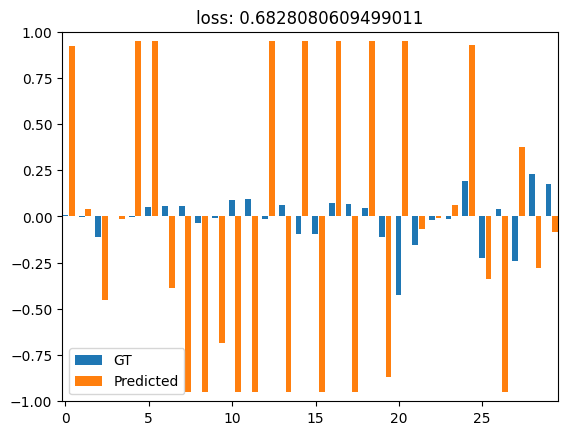

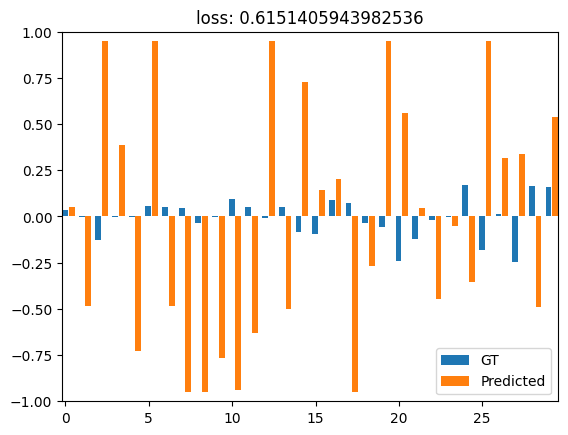

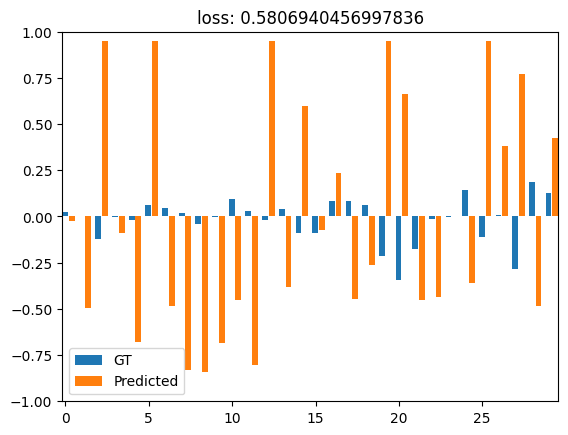

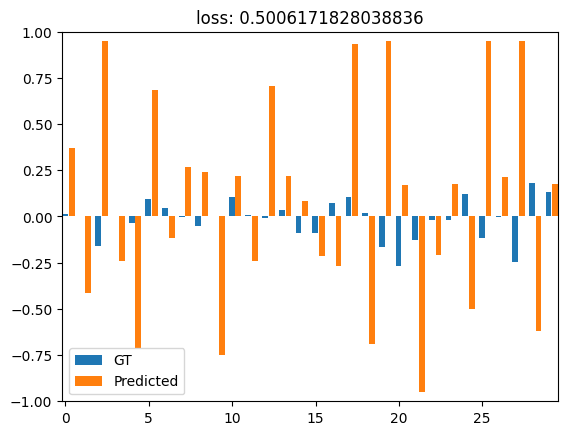

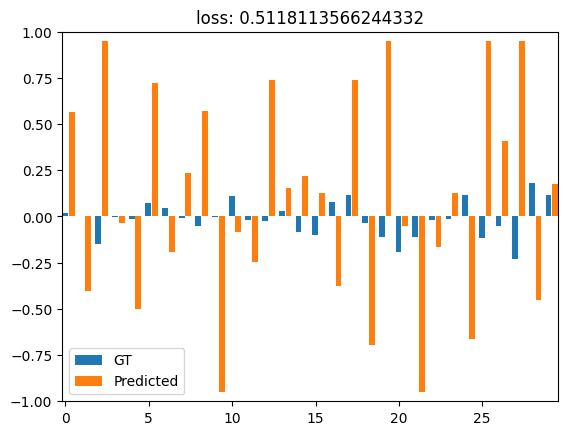

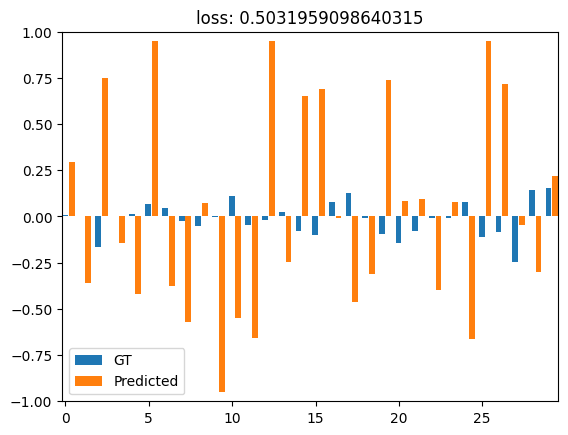

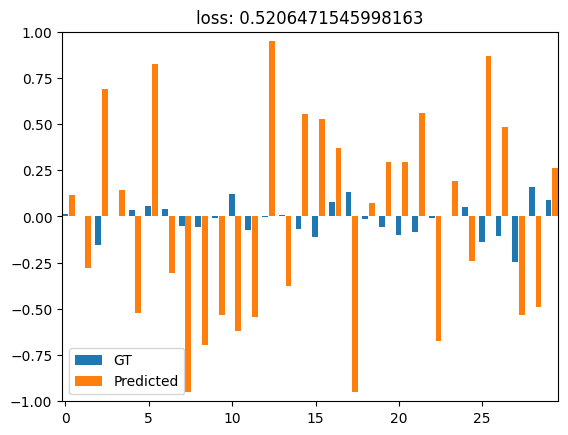

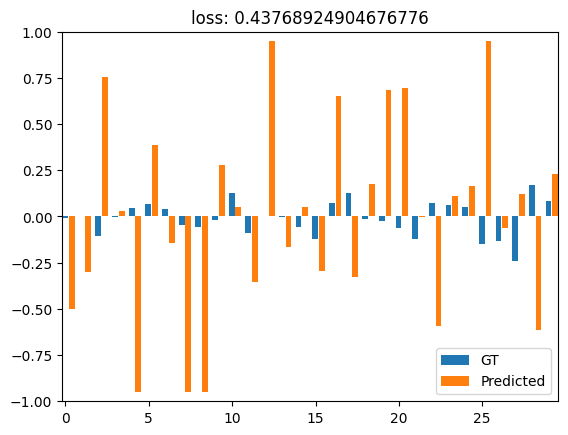

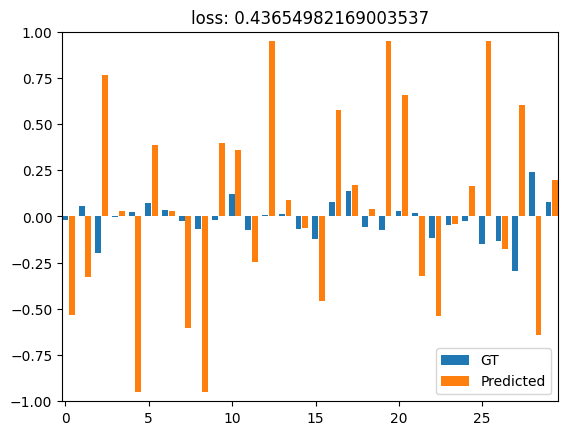

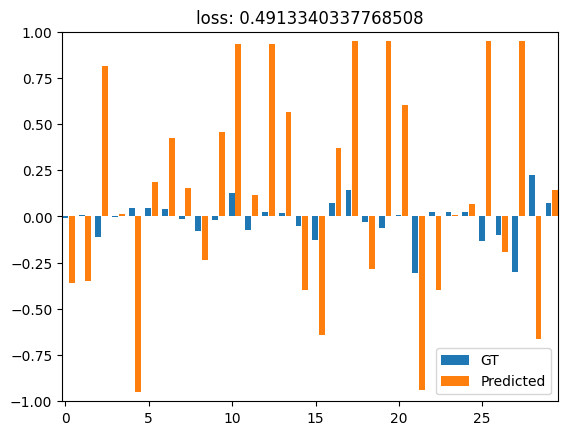

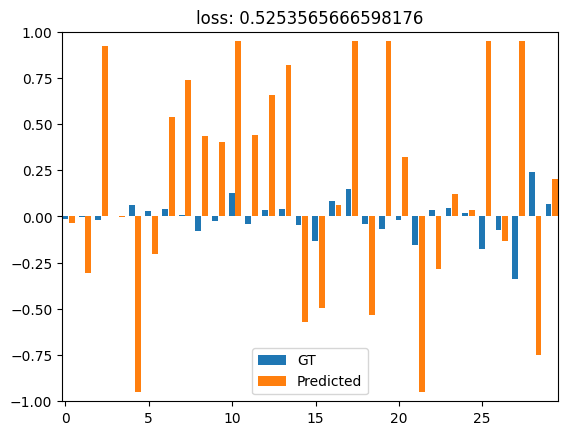

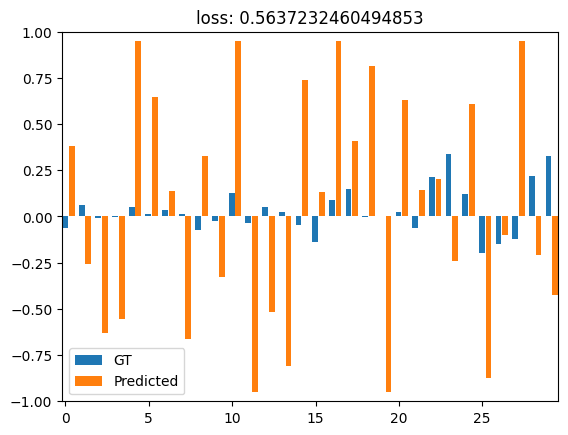

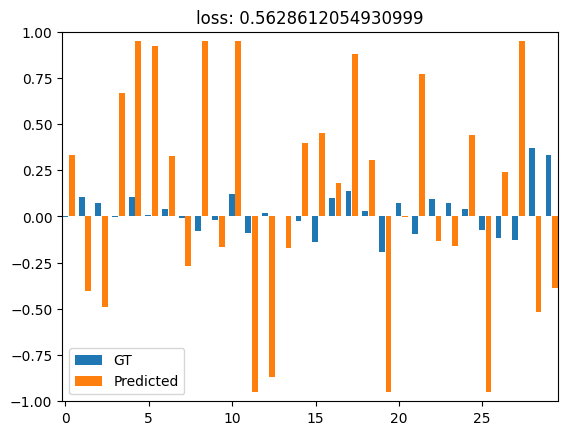

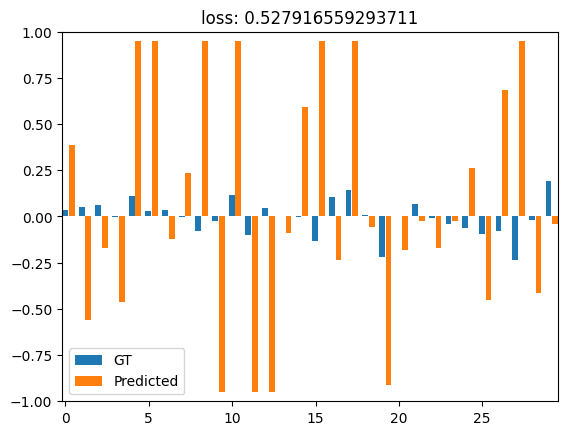

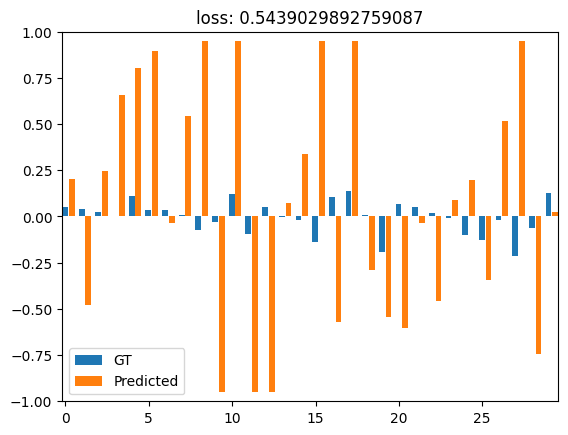

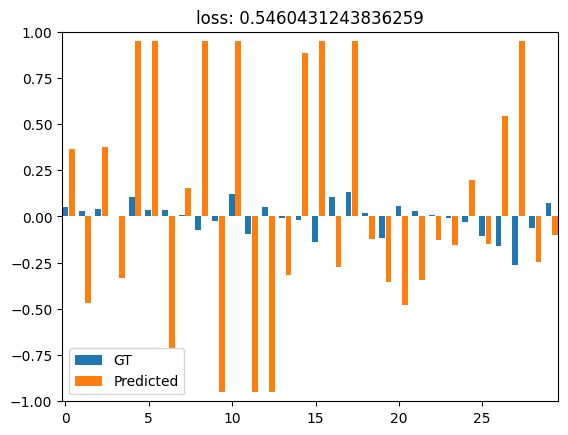

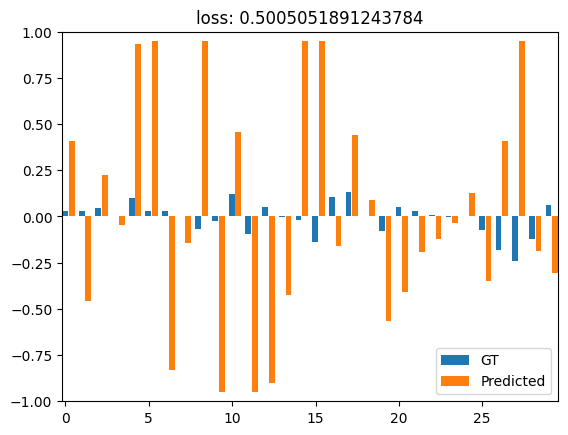

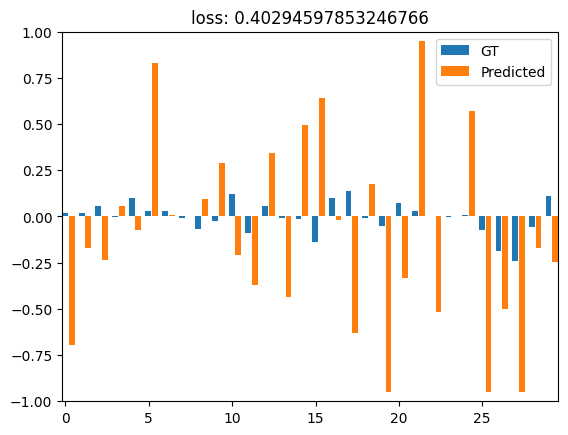

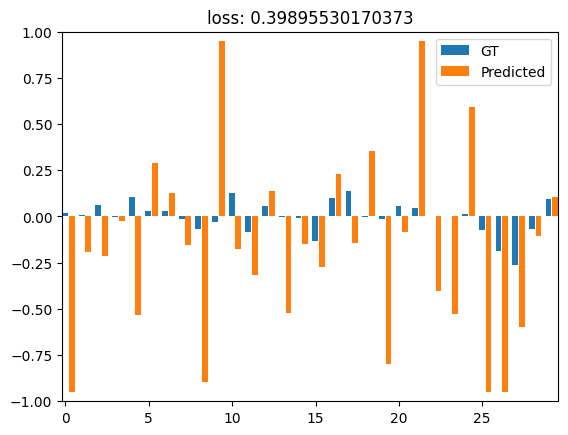

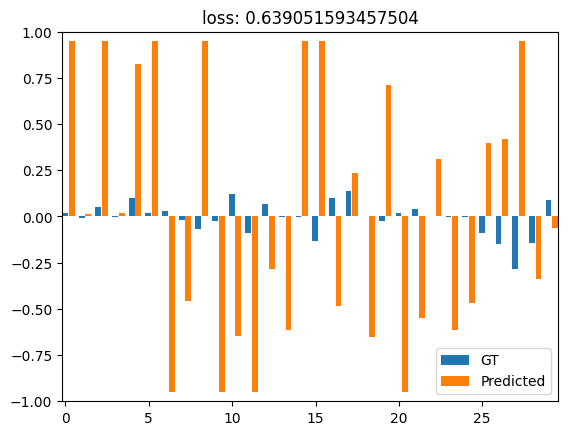

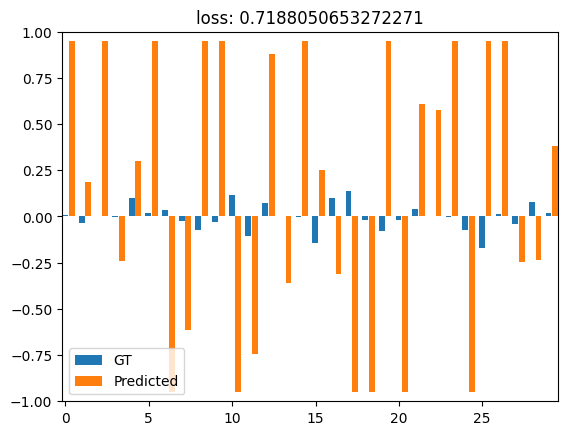

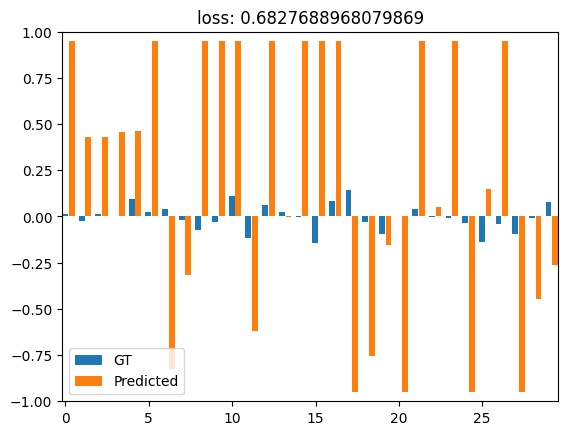

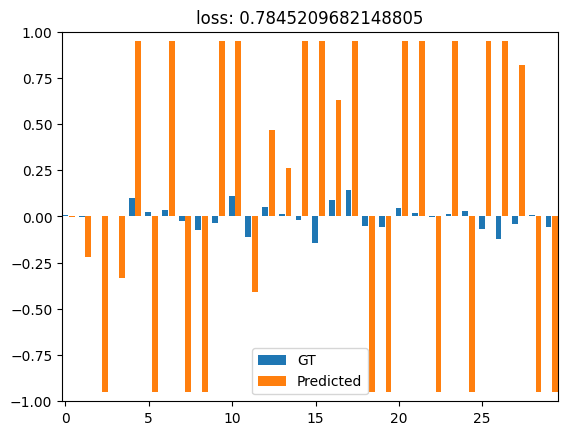

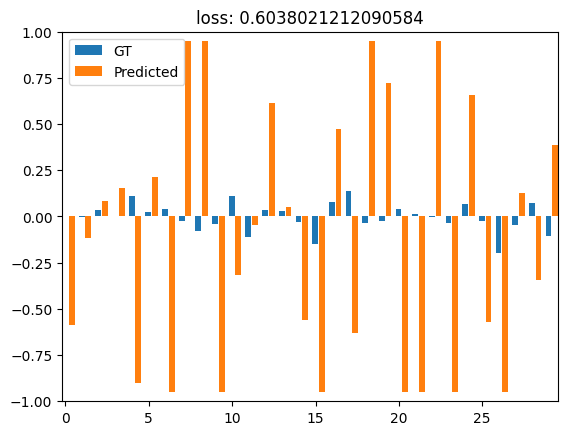

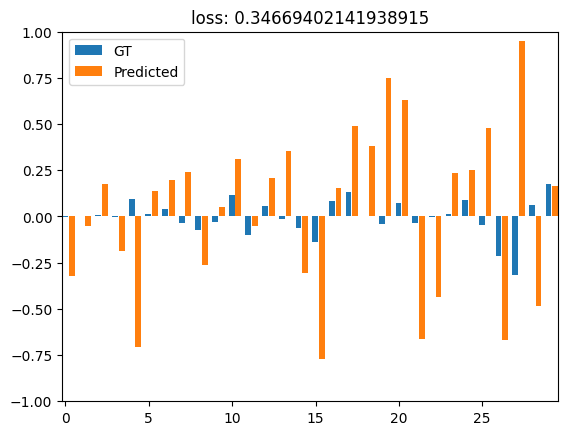

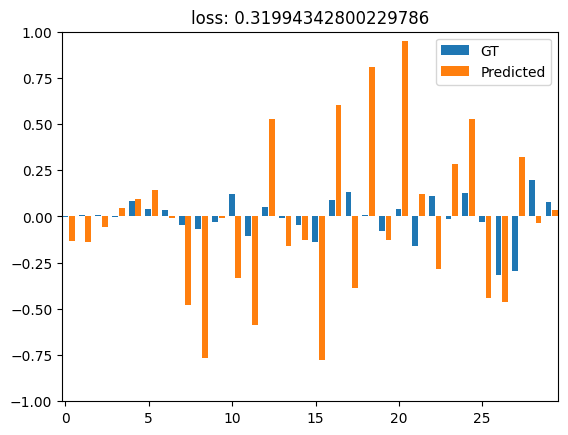

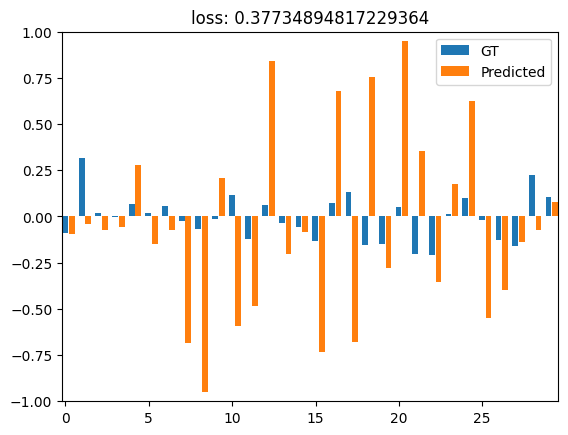

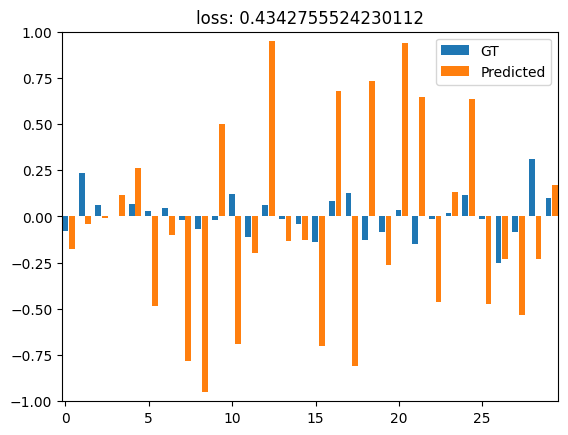

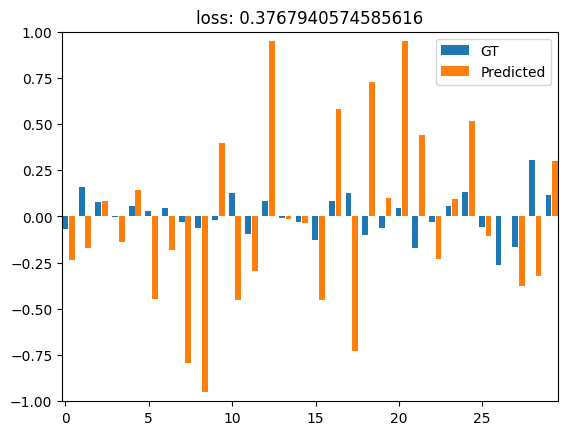

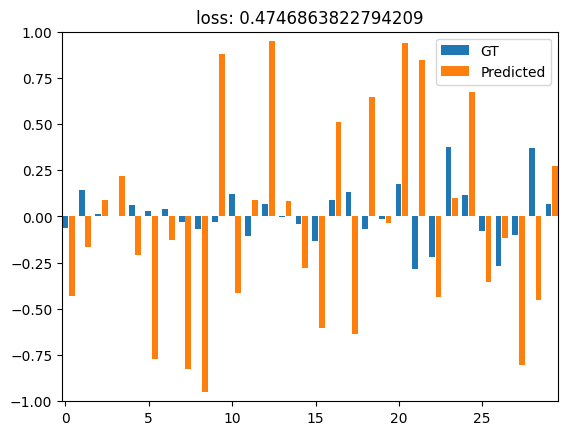

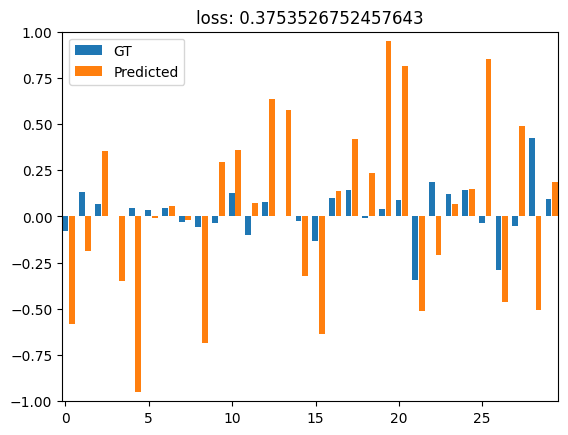

In [14]:
# Initialize MuJoCo viewer
env.init_viewer(viewer_title='Atlas',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=False)
env.update_viewer(azimuth=152,distance=3.0,elevation=-20,lookat=[0.02,-0.03,1.2])
env.reset()
image_list = []
for t in np.arange(20,315):
    PID.reset()
    rp = root_pos[50*t]
    rr = root_rot[50*t]
    rv = root_vel[50*t]
    rw = root_ang_vel[50*t]
    qpos = dof_pos[50*t]
    qvel = dof_vel[50*t]
#     print(rr[0])
    env.data.qvel = torch.cat((rv, rw, qvel))
    env.forward(torch.cat((rp, rr, qpos)))
    for h in range(100):
        ctrl = action[50*t+h]
        # state = obs[50*t+h]
        state = torch.from_numpy(np.concatenate((env.get_p_body('pelvis')[2:], r2quat(env.get_R_body('pelvis')), env.get_qvel_joint('pelvis')[0:3], env.get_qvel_joint('pelvis')[3:6], env.data.qpos[env.rev_joint_idxs+6].copy(), env.data.qvel[env.rev_joint_idxs+5].copy(), (env.data.xpos[key_body_ids]-env.get_p_body('pelvis')).reshape(12)), axis=-1)).type(torch.float32)
        pred_target_position, _, _, _ = policy(state)
        PID.update(x_trgt=pred_target_position,x_curr=state[11:41],VERBOSE=False)
        pred_torque = PID.out()
        pred_action=policy.action_mean_std(pred_torque, denorm=True).detach().numpy() / env.model.actuator_gear[:,0]

        env.step(pred_torque.detach().numpy())
        if env.loop_every(tick_every=1):
            # Plot world frame
            env.plot_T(p=np.zeros(3),R=np.eye(3,3),
                    PLOT_AXIS=True,axis_len=0.5,axis_width=0.005)
            env.plot_T(p=np.array([0,0,0.5]),R=np.eye(3,3),
                    PLOT_AXIS=False,label="tick:[%d]"%(env.tick))

            # # Stand
            # for p_GT in GT['xpos'][int(t+h)]:
            #     env.plot_sphere(p=p_GT,r=0.02,rgba=[1,0.2,0.2,1])
            
            env.render()

            # if SAVE_VID:
            #     # Save iamges
            #     png_path = '../temp/smplrig_MPC_%05d.png'%(env.tick)
            #     create_folder_if_not_exists(png_path)
            #     image = cv2.cvtColor(env.grab_image(),cv2.COLOR_RGB2BGR)
            #     cv2.imwrite(png_path,image)
            if PLOT:
                fig, ax = plt.subplots()
                plt.ylim(-1, 1)
                ax.bar(np.arange(action_dim)-0.2, ctrl, width = 0.35, align='edge', label='GT')
                ax.bar(np.arange(action_dim)+0.2, pred_torque.detach(), width = 0.35, align='edge', label='Predicted')
                ax.set_title("loss: {}".format(
                    torch.mean(torch.abs(ctrl-pred_torque.detach()))
                ))
                ax.legend()
                ax.margins(0)
                fig.canvas.draw()

                image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
                image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))

                image_list.append(image_from_plot)


In [ ]:
with media.VideoWriter(
    "atlas behavior cloning eval.mp4", shape=(480, 640), fps=5) as w:
    for image in image_list:
        w.add_image(image)

In [ ]:
policy.state_dict()